# **PREVISÃO DE CUSTOS DE SEGURO DE SAÚDE**

---
O objetivo deste estudo é realizar a previsão do custo de seguro de saude, com base nos atributos fisicos, paternidade, região, se é fumante ou não.

O dataset está disponivel no kaggle.

https://www.kaggle.com/datasets/mirichoi0218/insurance

### **BIBLIOTECAS UTILIZADAS** ###

Nesta seção está todas as bibliotecas que foram utilizadas ao decorrer do projeto, abrangendo a EDA, pre-processamento, modelagem.

In [1]:
#IMPORTAÇÃO DAS BIBLIOTECAS

#manipulação de dados e dataframe
import pandas as pd
import numpy as np

#bibliotecas para analises graficas, Q-Q plot, outliers, histograma
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as sts

# testes estatisticos
from statsmodels.stats.diagnostic import lilliefors #teste de normalidade
from statsmodels.compat import lzip #teste de homocedasticidade
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #estatistica do modelos lineares
import statistics

# utilizadas para validação cruzada, divisão de treino e teste, criação de pipelines, pré-processamento das variaveis
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

#modelos de ml e regressores
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.svm import SVR # MAQUINA DE VETOR DE SUPORTE
from sklearn.tree import DecisionTreeRegressor # ARVORE DE DECISÃO REGRESSOR
from sklearn.ensemble import RandomForestRegressor # RANDOM FOREST REGRESSOR
from xgboost import XGBRegressor as XGBR # XGBOOST
from lightgbm import LGBMRegressor  as LHTR # LIGHTGBM
from catboost  import CatBoostRegressor as CTBR # CATBOOST
from sklearn.neural_network import MLPRegressor # regressor rede neural

#instalar essas bibliotecas sempre que for rodar do notebook
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

#para salvar o modelo ja com o pipeline pronto (modelo + pre-processamento)
import joblib

#ignorar avisos
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


**IMPORTAÇÃO DOS DADOS**

In [2]:
#importação da base de dados
dados = pd.read_csv('../data/raw/insurance.csv', encoding = 'utf-8')
display(dados.head())
dados.shape

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7)

## **EDA**
---

Nesta estapa uma visualização inicial do dataset, com estatísticas descritivas de cada variável (média, desvio padrão, quartis, valores máximo e mínimo, contagem) e identificação dos tipos de dados (float, int, object, str), além da verificação de valores ausentes.

Em seguida, foi feita uma análise estatística detalhada das variáveis para entender o comportamento dos dados.
Foram utilizados:

Q-Q Plot e Histplot para verificar a distribuição e indícios de normalidade.

Boxplot para observar possíveis outliers e decidir entre tratá-los ou mantê-los.

Histogramas e gráficos de pizza para explorar a variável alvo (target), observando a proporção e o balanceamento entre as classe


In [7]:
#Frequencia dos valores nulos em cada variavel
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
#tipos de cada variavel 2 int, 2 float, 3 object
dados.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
#estatiscia das variaveis
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
# MODA DAS VARIAVEIS
modas = {}
for coluna in dados:
  moda = statistics.multimode(dados[coluna])
  modas[coluna] = moda
print(modas)

{'age': [18], 'sex': ['male'], 'bmi': [32.3], 'children': [0], 'smoker': ['no'], 'region': ['southeast'], 'charges': [1639.5631]}


### **ANALISE DE OUTLIERS** ###
Verificando a presença de outliers nas feautures e target

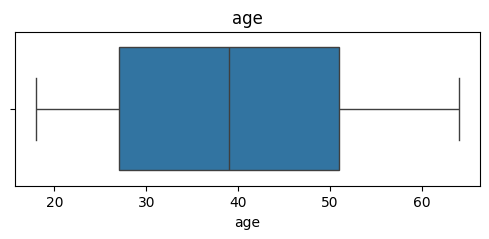

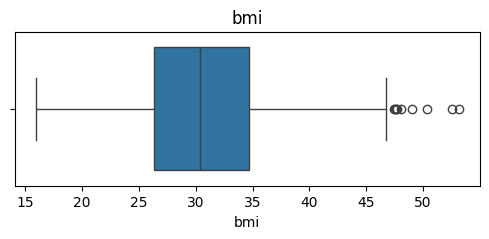

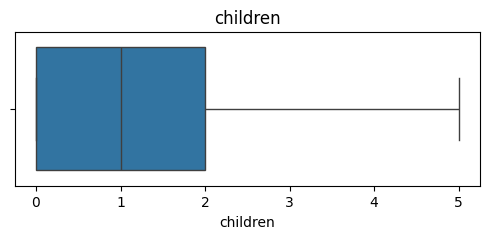

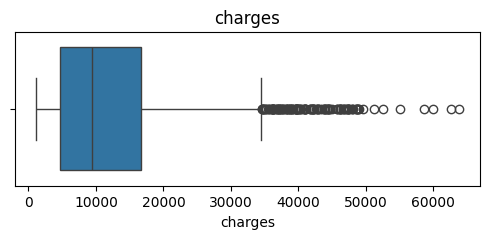

In [55]:
# CRIA UM GRÁFICO COM CADA BOXPLOT DAS FEATURES NUMÉRICAS E TARGET
fear = dados.select_dtypes(include="number")

for colunas in fear.columns:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=dados[colunas])
    plt.title(colunas)
    plt.show()


**bmi**

In [56]:
# QUANTIDADE DE OUTLIERS PRESENTE EM BMI 
# Quartis
Q1 = dados['bmi'].quantile(0.25)
Q3 = dados['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtro de outliers
outliers = dados[(dados['bmi'] < limite_inferior) | (dados['bmi'] > limite_superior)]

# Contagem
num_outliers = outliers.shape[0]

print(f"Número de outliers na coluna 'bmi': {num_outliers}")

Número de outliers na coluna 'bmi': 9


**charges**

In [57]:
# QAUNTIDADE DE OUTLIERS PRESENTE NO TARGET
# Quartis
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtro de outliers
outliers = dados[(dados['charges'] < limite_inferior) | (dados['charges'] > limite_superior)]

# Contagem
num_outliers = outliers.shape[0]

print(f"Número de outliers na coluna '{coluna}': {num_outliers}")

Número de outliers na coluna 'charges': 139


### **CORRELAÇÃO ENTRE AS VARIAVEIS** ###
gráfico de dispersão para analisar a correlação entre as features/target e histograma para distribuição das mesmas

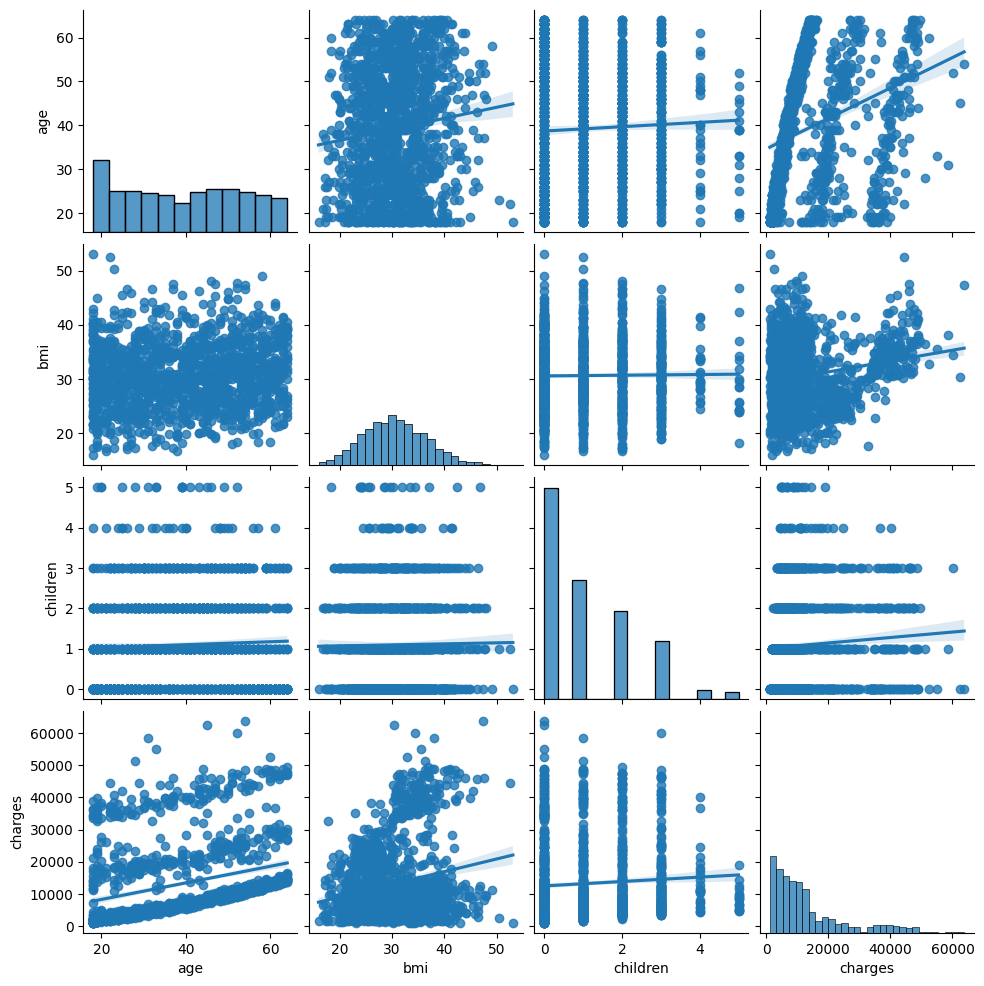

In [66]:
# CRIA UMA MATRIZ COM AS CORRELAÇÕES GRÁFICAS DE CADA VARIAVEL E NA DIAGONA DIREITA, A DISTRIBUIÇÃO ATRAVÉS DO HISPLOT
sns.pairplot(dados[['age', 'bmi', 'children', 'charges']], kind='reg')
plt.show()

### **DISTRIBUIÇÃO DOS DADOS**  ###

Analisando a distribuição dos dados através de histograma, Q-Q PLOT e aplicando testes de normalidade

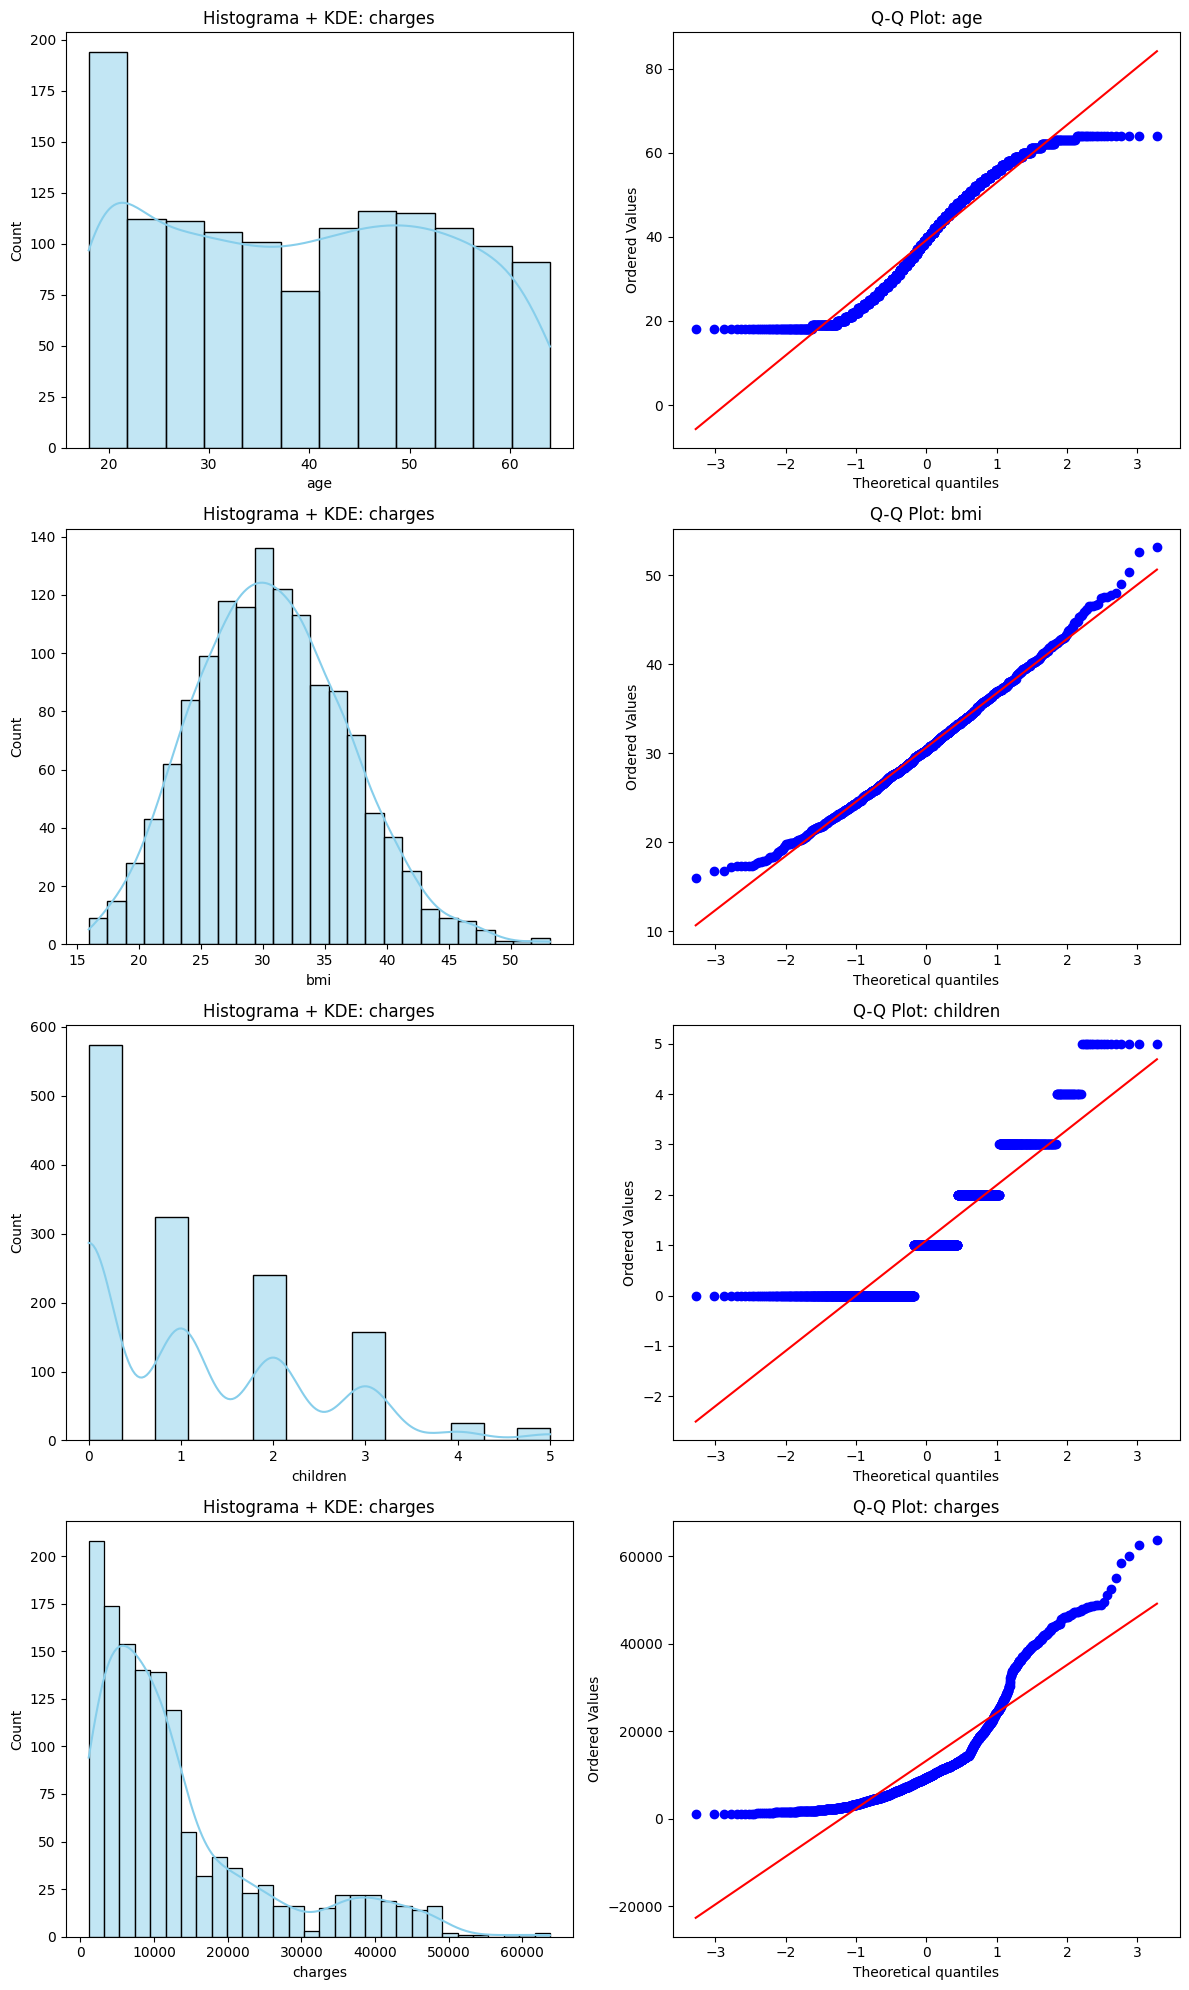

In [75]:
# Seleciona apenas colunas numéricas
numeric_cols = dados.select_dtypes(include=['int64', 'float64']).columns

# Define tamanho da figura e grade de subplots
numero_cols = 2  # 2 gráficos por linha: hist + qq
numero_rows = len(num_cols)  # 1 linha por variável
plt.figure(figsize=(12, 5 * n_rows))

for i, colunas in enumerate(numeric_cols):
    # Histograma com KDE
    plt.subplot(numero_rows, 2, 2*i + 1)
    sns.histplot(dados[colunas], kde=True, color='skyblue')
    plt.title(f'Histograma + KDE: {col}')
    
    # Q-Q plot
    plt.subplot(numero_rows, 2, 2*i + 2)
    stats.probplot(dados[colunas], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {colunas}')

plt.tight_layout()
plt.show()


**Aplicando testes de normalidade**

teste estatistico de normalidade para cada feature/target

**shapiro-wilk**

In [ ]:
#não segue uma distribuição normal p = 5.69204692845418e-22
sts.shapiro(dados.age)

ShapiroResult(statistic=np.float64(0.9447009637825445), pvalue=np.float64(5.69204692845418e-22))

In [ ]:
#não segue uma distribuição normal p = 2.60468368798344e-05
sts.shapiro(dados.bmi)

ShapiroResult(statistic=np.float64(0.9938864621676107), pvalue=np.float64(2.60468368798344e-05))

In [ ]:
#não segue uma distribuição normal p = 5.066436570900864e-36
sts.shapiro(dados.children)

ShapiroResult(statistic=np.float64(0.823180467362945), pvalue=np.float64(5.066436570900864e-36))

In [ ]:
#não segue uma distribuição normal p = 1.1505226334932036e-36
sts.shapiro(dados.charges)

ShapiroResult(statistic=np.float64(0.8146881157362383), pvalue=np.float64(1.1505226334932036e-36))

**lilliefors (klomogorv smirnov)**

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.age)

(np.float64(0.07894454646849702), np.float64(0.0009999999999998899))

In [ ]:
#distribuição não é normal p = 0.04431273291697496
lilliefors(dados.bmi)

(np.float64(0.026099881197044872), np.float64(0.04431273291697496))

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.children)

(np.float64(0.2471317838278972), np.float64(0.0009999999999998899))

In [ ]:
#distribuição não é normal p = 0.0009999999999998899
lilliefors(dados.charges)

(np.float64(0.18846450965981876), np.float64(0.0009999999999998899))

## **pre**

In [ ]:
#converter as categoricas em continuas com objetivo de plotar as correlações
dados_encoding = dados.copy() #criando uma coóia do df para aplicar o ordinal
var_cat = ['sex','smoker','region'] #colunas categoritcas
encoding_ordi = OrdinalEncoder() #criação do OrdinalEncoder
cat_cols = dados_encoding.select_dtypes(include=['object']).columns #selecionando somente as colunas categoricas
dados_encoding[cat_cols] = encoding_ordi.fit_transform(dados_encoding[cat_cols]) #transoformando categoricas
dados_encoding[cat_cols] = dados_encoding[cat_cols].astype(int) # convertendo a transformação de float para int
dados_encoding #exibindo o df


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [ ]:
#Ordem das classes codiificadas pelo OrdinalEncoder()
for coluna, classes in zip(var_cat, encoding_ordi.categories_):
    print(f"{coluna}: {classes}")

sex: ['female' 'male']
smoker: ['no' 'yes']
region: ['northeast' 'northwest' 'southeast' 'southwest']


**Matriz de correlação entre as variaveis**

In [ ]:
#Matrix de correlação
matriz_correlacao = dados_encoding.corr(method='spearman')
matriz_correlacao

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020809,0.107736,0.056992,-0.025210,0.004315,0.534392
sex,-0.020809,1.000000,0.044802,0.015589,0.076185,0.004614,0.009490
bmi,0.107736,0.044802,1.000000,0.015607,0.002203,0.152959,0.119396
children,0.056992,0.015589,0.015607,1.000000,0.016583,0.010604,0.133339
smoker,-0.025210,0.076185,0.002203,0.016583,1.000000,-0.002155,0.663460
region,0.004315,0.004614,0.152959,0.010604,-0.002155,1.000000,-0.043531
charges,0.534392,0.009490,0.119396,0.133339,0.663460,-0.043531,1.000000


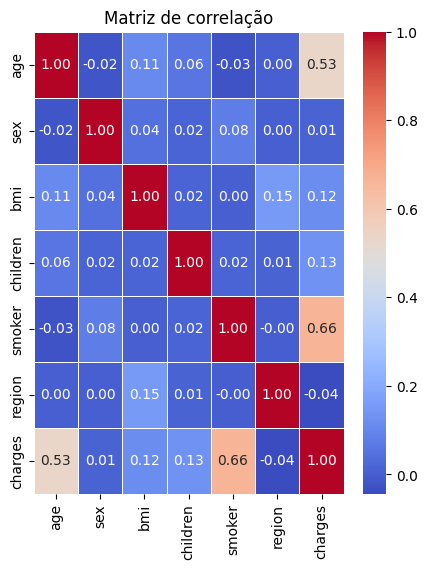

In [ ]:
#matriz plotada
plt.figure(figsize=(5,6))
sns.heatmap(matriz_correlacao, annot = True, cmap = 'coolwarm', fmt ='.2f', linewidths = .5)
plt.title('Matriz de correlação')
plt.show()

#**REGRESSÃO LINEAR SIMPLES (charges ~ age)**

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
#feature age
age_valores = dados.iloc[:, 0:1].values
age_valores

array([[19],
       [18],
       [28],
       ...,
       [18],
       [21],
       [61]])

In [ ]:
#target
charges_valores = dados.iloc[:, 6].values
charges_valores

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [ ]:
#divisão de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(age_valores, charges_valores, test_size= 0.3, random_state = 5)

In [ ]:
#forma do treino
x_treino.shape, y_treino.shape

((936, 1), (936,))

In [ ]:
#forma do teste
x_teste.shape, y_teste.shape

((402, 1), (402,))

**Equação = 3563.519102396467 + 252.07288089*age**

In [ ]:
#criação do regressos
regressor_linear = LinearRegression()
regressor_linear.fit(x_treino, y_treino)

LinearRegression()

In [ ]:
# coeficiente angular do modelo
regressor_linear.coef_

array([252.07288089])

In [ ]:
#intercepto do modelo
regressor_linear.intercept_

np.float64(3563.519102396467)

In [ ]:
#coeficiente de determinação do teste
regressor_linear.score(x_treino, y_treino)

0.0820622585490427

In [ ]:
#previsoes do treino
previsoes_treino = regressor_linear.predict(x_treino)
previsoes_treino

array([16167.1631471 , 11125.70552922, 18183.74619425, 17175.45467067,
       19444.11059872, 13394.36145726, 11629.85129101, 16419.23602799,
       18687.89195604, 13394.36145726,  8100.83095849, 17679.60043246,
       13142.28857637,  8352.90383938, 15158.87162352,  8100.83095849,
       18939.96483693, 19192.03771783, 12638.14281458, 18687.89195604,
       16923.38178978, 14654.72586173, 16419.23602799, 13898.50721905,
       17175.45467067, 15410.94450442, 17931.67331336, 18183.74619425,
       16419.23602799, 19696.18347961,  8352.90383938, 17679.60043246,
        9613.26824385,  8604.97672028, 15158.87162352, 12890.21569548,
        8100.83095849,  9865.34112475, 17931.67331336, 15915.0902662 ,
       13898.50721905, 18435.81907514, 16923.38178978, 11629.85129101,
       14654.72586173, 16923.38178978, 15663.01738531, 13142.28857637,
       10621.55976743, 17931.67331336, 15158.87162352, 10369.48688653,
       15410.94450442, 16671.30890889, 16671.30890889,  9361.19536296,
      

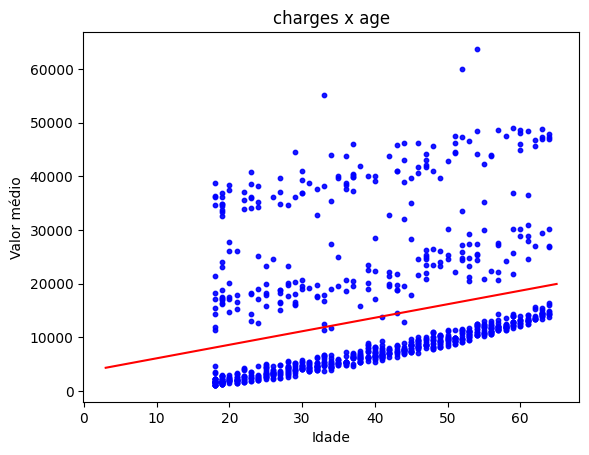

In [ ]:
#ajuste da reta em relação aos dados
plt.scatter(y = y_treino, x =  x_treino,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(3,65) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('charges x age') #titulo do grafico
plt.ylabel('Valor médio') # titulo eixo y
plt.xlabel('Idade') # titulo eixo x
plt.show() # exibindo o grafico


In [ ]:
#coeficiente de determinação do teste
regressor_linear.score(x_teste, y_teste)

0.10267650072154177

In [ ]:
#previsoes do regressor
previsoes_teste = regressor_linear.predict(x_teste)
previsoes_teste

array([ 8100.83095849,  9613.26824385, 17175.45467067,  9109.12248206,
       12386.06993369, 14654.72586173, 15410.94450442, 16167.1631471 ,
        9865.34112475, 16923.38178978, 19192.03771783, 17679.60043246,
        8100.83095849, 15663.01738531, 15410.94450442, 12638.14281458,
       14150.58009995, 15915.0902662 , 15915.0902662 , 13142.28857637,
        9109.12248206,  8352.90383938,  8352.90383938, 10873.63264832,
       10369.48688653, 12386.06993369, 17427.52755157, 19696.18347961,
       18939.96483693, 19444.11059872, 14150.58009995,  8352.90383938,
        8857.04960117, 15663.01738531, 15663.01738531,  8100.83095849,
       11881.9241719 ,  8857.04960117, 10117.41400564, 10369.48688653,
        8100.83095849, 19696.18347961, 10621.55976743, 12386.06993369,
       16167.1631471 , 14402.65298084, 16167.1631471 ,  9361.19536296,
       16671.30890889,  8352.90383938,  9361.19536296, 11377.77841011,
       10621.55976743,  9361.19536296,  9613.26824385, 13142.28857637,
      

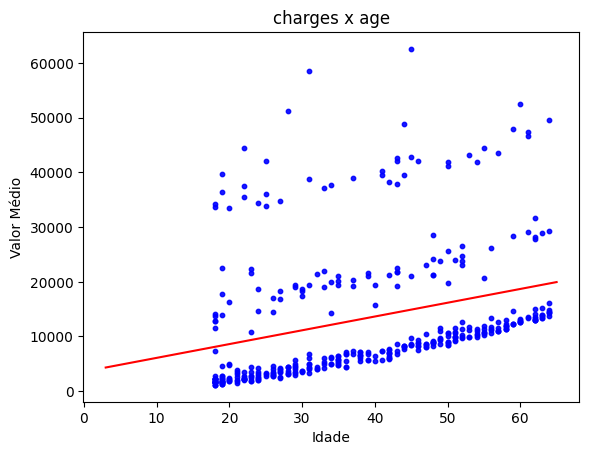

In [ ]:
# ajuste da reta em relação aos dados
plt.scatter(y = y_teste, x =  x_teste,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(3,65) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para regressão contendo o RM e o MEDV
plt.title('charges x age') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Idade') # titulo eixo x
plt.show() # exibindo o grafico

In [ ]:
#previsão do valor medio
valor_medio = regressor_linear.predict([[25]])
valor_medio

array([9865.34112475])

**metricas de desempenho (charges x  age)**

In [ ]:
#erro medio abosluto
mean_absolute_error(y_teste, previsoes_teste)

8867.840003327274

In [ ]:
#erro medio quadratico
mean_squared_error(y_teste, previsoes_teste)

127589203.83739154

In [ ]:
#raiz do erro medio quadratico
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

np.float64(11295.53911229524)

**validação cruzada**

In [ ]:
#validação cruzada do modelo
kfold = KFold(n_splits = 15,shuffle = True,random_state = 10)
resultado = cross_val_score(regressor_linear,age_valores, charges_valores,cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 7.09%


**avaliação do modelo com statsmodels**

In [ ]:
#criação do modelo
regressor_sts = smf.ols('charges_valores ~ age_valores', data = dados).fit()

In [ ]:
#residuos do modelo linear
residuos = regressor_sts.resid
residuos

,0
0,8822.309239
1,-6079.339842
2,-5932.656329
3,10313.739188
4,-7546.153603
...,...
1333,-5451.467639
1334,-5598.911342
1335,-6175.058642
1336,-6570.114998


In [ ]:
#normalidade dos risiduos
estatistica_teste, p = lilliefors(residuos)
print('Estatistica do teste:{}, p valor: {}'.format(estatistica_teste, p))

Estatistica do teste:0.35265247538203115, p valor: 0.0009999999999998899


Text(0.5, 1.0, 'Residuos (charges x age)')

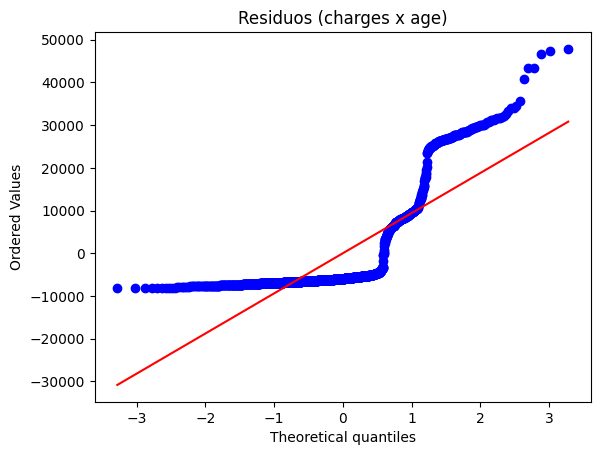

In [ ]:
#analise dos residuos
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Residuos (charges x age)')

In [ ]:
#homocedasticidade dos residuos
#teste de homocedasticidade p > 0.05 = dados homogenios, p <= 0.05 =  dados não homogenios (grande variancia)
estatistica, p, f, fp = sms.het_breuschpagan(regressor_sts.resid, regressor_sts.model.exog)
print('estatistica do teste: {}'.format(estatistica))
print('p_valor: {}'.format(p))
print('f_valor: {}'.format(f))
print('fp_valor: {}'.format(fp))

estatistica do teste: 0.0004134966681730301
p_valor: 0.9837764407329392
f_valor: 0.0004128787140921975
fp_valor: 0.9837916004512588


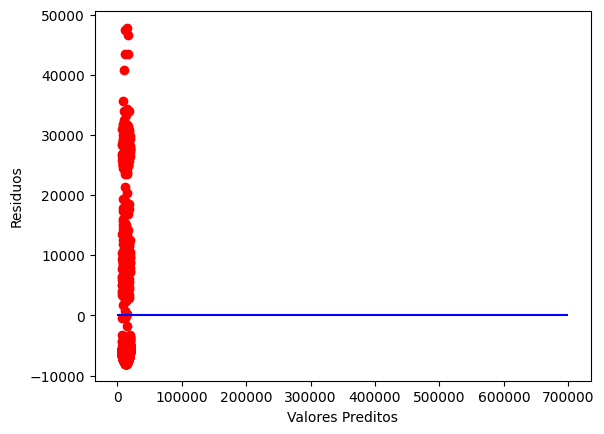

In [ ]:
#homocedasticidades dos residuos
plt.scatter(y = residuos, x = regressor_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin = 0, xmax = 700000, color = 'blue')
plt.ylabel('Residuos')
plt.xlabel('Valores Preditos')
plt.show()

In [ ]:
#outliers do residuos
outliers = regressor_sts.outlier_test()
print('Outliers maximo: {}, Outliers minimo: {}'.format(outliers.max(), outliers.min()))

Outliers maximo: student_resid    4.164437
unadj_p          0.999514
bonf(p)          1.000000
dtype: float64, Outliers minimo: student_resid   -0.697265
unadj_p          0.000033
bonf(p)          0.044441
dtype: float64


In [ ]:
#sumario do modelo criado
print(regressor_sts.summary())

                            OLS Regression Results                            
Dep. Variable:        charges_valores   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           4.89e-29
Time:                        21:52:52   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3165.8850    937.149      3.378      

#**REGRESSÃO LINEAR SIMPLES (charges ~ smoker)**

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
dados_encoding

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [ ]:

smoker_valores = dados_encoding.iloc[:, 4:5].values
smoker_valores

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
charges_valores

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(smoker_valores, charges_valores,test_size = 0.3,random_state = 5)

In [ ]:
x_treino.shape, y_treino.shape

((936, 1), (936,))

In [ ]:
x_teste.shape, y_teste.shape

((402, 1), (402,))

In [ ]:
#modelo criado, charges em função de smoker
regressor_linear = LinearRegression()
regressor_linear.fit(x_treino, y_treino)

LinearRegression()

In [ ]:
#intercepto
regressor_linear.intercept_

np.float64(8721.775904061662)

In [ ]:
#coeficiente de angular
regressor_linear.coef_

array([23748.31664362])

In [ ]:
#coeficiente de determinação
regressor_linear.score(x_treino, y_treino)

0.6158238346847231

In [ ]:
#coeficiente de determinação
regressor_linear.score(x_teste, y_teste)

0.6254090050905078

**Equação =  8721.775904061662 + 23748.31664362*smoker**

In [ ]:
#previsoes do treino
previsoes_treino = regressor_linear.predict(x_treino)
previsoes_treino

array([ 8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
       32470.09254768,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768,  8721.77590406, 32470.09254768,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406, 32470.09254768,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
      

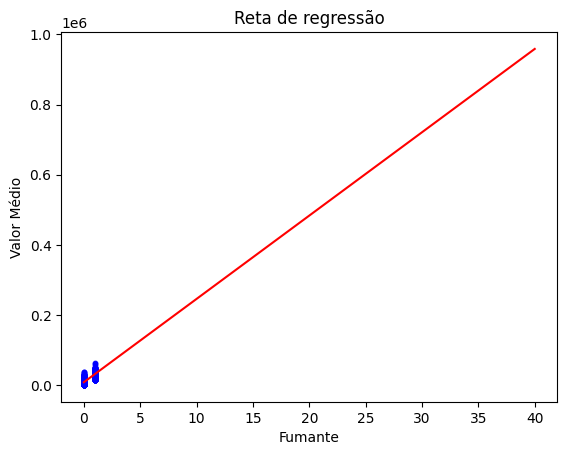

In [ ]:
plt.scatter(y = y_treino, x =  x_treino,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(0,40) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('Reta de regressão') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Fumante') # titulo eixo x
plt.show() # exibindo o grafico

In [ ]:
#previsoes do teste
previsoes_teste = regressor_linear.predict(x_teste)
previsoes_teste

array([ 8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
       32470.09254768,  8721.77590406,  8721.77590406,  8721.77590406,
       32470.09254768,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
        8721.77590406, 32470.09254768, 32470.09254768, 32470.09254768,
        8721.77590406,  8721.77590406, 32470.09254768,  8721.77590406,
        8721.77590406,  8721.77590406,  8721.77590406, 32470.09254768,
        8721.77590406,  8721.77590406,  8721.77590406,  8721.77590406,
      

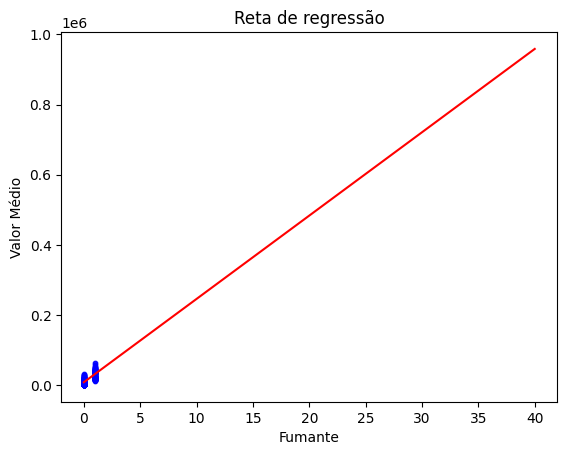

In [ ]:
plt.scatter(y = y_teste, x =  x_teste,color = 'blue', s = 10, alpha = 0.9) #criação do grafico definindo o eixo y e eixo x
x_plot = np.linspace(0,40) #espaçamento do grafico
plt.plot(x_plot, x_plot * regressor_linear.coef_ + regressor_linear.intercept_, color = 'red') #equação montada para a reta ajustada
plt.title('Reta de regressão') #titulo do grafico
plt.ylabel('Valor Médio') # titulo eixo y
plt.xlabel('Fumante') # titulo eixo x
plt.show() # exibindo o grafico

In [ ]:
valores_previstos = regressor_linear.predict([[0]])
valores_previstos

array([8721.77590406])

**metricas de desempenho**

In [ ]:
mean_absolute_error(y_teste,previsoes_teste)

5679.058587380427

In [ ]:
mean_squared_error(y_teste, previsoes_teste)

53262582.38371076

In [ ]:
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

np.float64(7298.1218394673815)

**validação cruzada**

In [ ]:
#validação cruzada
resultado = cross_val_score(regressor_linear, smoker_valores, charges_valores, cv = kfold)
print('Coeficiente de determninção médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determninção médio: 59.85%


**pré-supostos**

In [ ]:
#criação do regressor
regressor_sts = smf.ols('charges_valores ~ smoker_valores', data = dados_encoding).fit()

In [ ]:
#residuos
residuos = regressor_sts.resid
residuos

,0
0,-15165.307832
1,-6708.715998
2,-3984.806298
3,13550.202312
4,-4567.413098
...,...
1333,2166.280002
1334,-6228.287498
1335,-6804.434798
1336,-6426.323298


In [ ]:
#testando a normalidade dos residuos
estatistica, p = sts.shapiro(residuos)
print('estatistica do teste: {}'.format(estatistica))
print("valor p: {}".format(p))

estatistica do teste: 0.9608359484286372
valor p: 1.6718489951481798e-18


Text(0.5, 1.0, 'Q-Q PLOT dos residuos')

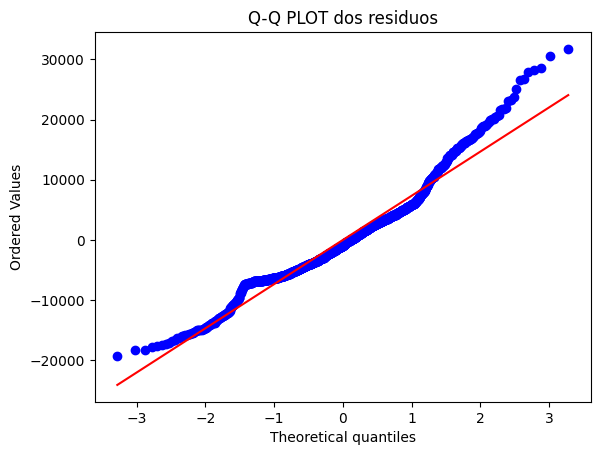

In [ ]:
#analise dos residuos
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Q-Q PLOT dos residuos')

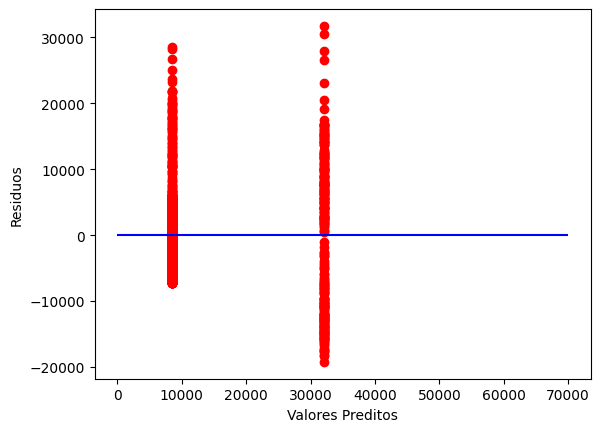

In [ ]:
#homocedasticidades dos residuos
plt.scatter(y = residuos, x = regressor_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin = 0, xmax = 70000, color = 'blue')
plt.ylabel('Residuos')
plt.xlabel('Valores Preditos')
plt.show()

In [ ]:
#teste de homocedasticidade p > 0.05 = dados homogenios, p <= 0.05 =  dados não homogenios (grande variancia)
estatistica, p, f, fp = sms.het_breuschpagan(regressor_sts.resid, regressor_sts.model.exog)
print('estatistica do teste: {}'.format(estatistica))
print('p_valor: {}'.format(p))
print('f_valor: {}'.format(f))
print('fp_valor: {}'.format(fp))

estatistica do teste: 199.39758908614832
p_valor: 2.8267826039452625e-45
f_valor: 233.96681446096989
fp_valor: 8.597416429754152e-49


In [ ]:
#outliers
outliers = regressor_sts.outlier_test()
print(f'Outliers minimo: {outliers.min()}, outlier maximo: {outliers.max()}')

Outliers minimo: student_resid   -2.583163
unadj_p          0.000020
bonf(p)          0.026614
dtype: float64, outlier maximo: student_resid    4.281495
unadj_p          0.999338
bonf(p)          1.000000
dtype: float64


In [ ]:
#estatistias do regressor
print(regressor_sts.summary())

                            OLS Regression Results                            
Dep. Variable:        charges_valores   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2178.
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          8.27e-283
Time:                        21:52:53   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1336   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8434.2683    229.014     36.

#**REGRESSÃO LINEAR MULTIPLA**

In [ ]:
#features
independentes = dados_encoding.iloc[:, 0:6].values
independentes

array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
       [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
       [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ],
       ...,
       [18.  ,  0.  , 36.85,  0.  ,  0.  ,  2.  ],
       [21.  ,  0.  , 25.8 ,  0.  ,  0.  ,  3.  ],
       [61.  ,  0.  , 29.07,  0.  ,  1.  ,  1.  ]])

In [ ]:
#target
dependente = dados_encoding.iloc[:, 6].values
dependente

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [ ]:
#divisão de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(independentes,dependente,test_size= 0.3,random_state = 5)

In [ ]:
#corpo do treino
x_treino.shape, y_treino.shape

((936, 6), (936,))

In [ ]:
#corpo do teste
x_teste.shape, y_teste.shape

((402, 6), (402,))

In [ ]:
#criação do modelo
multipla = LinearRegression()
multipla.fit(x_treino, y_treino)

LinearRegression()

In [ ]:
#intercepto
multipla.intercept_

np.float64(-11767.65023546448)

In [ ]:
#coeficiente angular
multipla.coef_

array([  260.1633228 ,  -308.27530049,   328.66308298,   602.34159086,
       24031.92915306,  -328.18271651])

In [ ]:
dados_encoding.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [ ]:
#quação montada
print("Equação: Valor = {:.2f} + ({:.2f})*age + ({:.2f})*sex + ({:.2f})*bmi + ({:.2f})*children + ({:.2f})*smoker + ({:.2f})*region".format(multipla.intercept_, multipla.coef_[0], multipla.coef_[1],
                                                                                                                                            multipla.coef_[2],  multipla.coef_[3], multipla.coef_[4], multipla.coef_[5]))

Equação: Valor = -11767.65 + (260.16)*age + (-308.28)*sex + (328.66)*bmi + (602.34)*children + (24031.93)*smoker + (-328.18)*region


In [ ]:
#coeficiente de determina do treino
multipla.score(x_treino, y_treino)

0.7468954747900357

In [ ]:
#previsão treino
previsoes_treino = multipla.predict(x_treino)
previsoes_treino

array([ 1.26902954e+04,  4.16433232e+03,  1.44723856e+04,  1.30218787e+04,
        1.58967436e+04,  7.67926242e+03,  4.27643416e+03,  1.38581218e+04,
        1.43936752e+04,  8.67806299e+03,  3.81211409e+03,  1.52324944e+04,
        9.52630982e+03,  4.21639422e+03,  1.11451622e+04,  5.62824359e+03,
        3.74045771e+04,  1.35924835e+04,  6.71534331e+03,  1.11987773e+04,
        1.45970239e+04,  3.61847095e+04,  8.53263145e+03,  9.78031093e+03,
        1.27448264e+04,  3.75301380e+04,  3.62346694e+04,  1.32160224e+04,
        7.28659059e+03,  1.49288553e+04,  3.90931439e+03,  1.59194002e+04,
        3.24703708e+03,  2.36478524e+04,  9.91836074e+03,  3.42142759e+04,
        5.34628811e+03,  2.41044102e+03,  1.15097415e+04,  1.16989439e+04,
        6.65145296e+03,  1.50849043e+04,  1.22280311e+04,  9.12227859e+03,
        7.51390648e+03,  3.35187225e+04,  1.45299027e+04,  9.86264872e+03,
        5.64453389e+03,  1.31931791e+04,  7.97814025e+03,  3.04904872e+04,
        7.99859968e+03,  

In [ ]:
#coeficiente de determinação do teste
multipla.score(x_teste,y_teste)

0.7574825064531082

In [ ]:
#previsão teste
previsoes_teste = multipla.predict(x_teste)
previsoes_teste

array([ 2812.9783187 , 28003.9431294 , 11641.21899878,  4803.26570367,
        8527.60628887, 35564.01662571, 11667.14768055, 11537.86884315,
        8528.98467807, 10876.33769211, 15361.65163122, 11017.09759765,
        5129.37047119,  9155.79306485,  8453.11211396,  9154.14178028,
       32174.30151291, 12682.126851  , 13491.86473327,  7681.89657901,
       29333.66019259,  1911.04284324,  2869.85089652,  3995.29193048,
        2831.00579376,  9383.29325355, 37485.83675916, 17126.17026189,
       10705.6341586 , 14089.57698985, 13343.55281684,   813.08799459,
        5625.21948895, 11018.16438135, 31813.43016461,  4206.49520554,
        6409.40952464,  2624.3779738 ,  6457.00862721,  5912.90477914,
        3394.02939308, 37422.6558459 , 30821.70631707, 30252.59539938,
       10741.41046681,  7666.19739417, 35423.87237266,  3129.92936564,
       19481.18420036,  4868.12244101, 10411.85316653, 29162.1476943 ,
        3813.17999727,  4208.90501073,   874.16220328,  7572.75517915,
      

In [ ]:
#target
y_teste

array([ 2203.47185 , 18648.4217  , 11305.93455 ,  2166.732   ,
        5245.2269  , 48885.13561 ,  8068.185   , 19749.38338 ,
        3238.4357  ,  9869.8102  , 12979.358   , 11165.41765 ,
        1633.0444  , 21232.18226 ,  8534.6718  ,  5584.3057  ,
       21259.37795 ,  9583.8933  , 11552.904   ,  6555.07035 ,
       35595.5898  ,  2710.82855 ,  2128.43105 ,  2867.1196  ,
        3561.8889  ,  5630.45785 , 44423.803   , 14410.9321  ,
       13415.0381  , 13880.949   ,  7650.77375 ,  1632.03625 ,
        3579.8287  ,  8283.6807  , 21223.6758  ,  1141.4451  ,
        5261.46945 ,  1526.312   ,  3987.926   , 16796.41194 ,
       11482.63485 , 29330.98315 , 51194.55914 , 20234.85475 ,
       10106.13425 ,  6837.3687  , 41097.16175 ,  2690.1138  ,
       12592.5345  ,  2136.88225 ,  2438.0552  , 19350.3689  ,
        4428.88785 , 10795.93733 ,  1969.614   ,  5974.3847  ,
       43254.41795 ,  3046.062   ,  8413.46305 , 19144.57652 ,
        9964.06    , 18765.87545 , 42124.5153  ,  1136.

In [ ]:
 #previsão de valor médio com registros externos
 valor_medio = multipla.predict([[25,0,23.00,0,1,1]])
 valor_medio

array([25999.43017946])

**metricas de desempenho**

In [ ]:
#erro medio absoluto
mean_absolute_error(y_teste, previsoes_teste)

4063.4311461869293

In [ ]:
#erro medio quadratico
mean_squared_error(y_teste, previsoes_teste)

34483231.457962215

In [ ]:
#RMSE raiz do erro medio quadratico
np.sqrt(mean_squared_error(y_teste, previsoes_teste))

np.float64(5872.242455652033)

**Validação Cruzada**

In [ ]:
#validação cruzada
resultado = cross_val_score(multipla, independentes, dependente, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 73.73%


**Avaliação do modelo de regressão linear multipla com statsmodels**

In [ ]:
#criação do modelo
multipla_sts = smf.ols('charges ~ age + sex + bmi + children + smoker + region', data = dados_encoding).fit()

In [ ]:
#obtenção dos residuos do modelo criado
residuos = multipla_sts.resid
residuos

,0
0,-8226.317864
1,-1962.052873
2,-2513.683707
3,18243.162205
4,-1670.785697
...,...
1333,-1701.457702
1334,-1225.390847
1335,-2733.828866
1336,900.958387


In [ ]:
#Os residuos n seguem uma distribuição normal
estatistica, p = lilliefors(residuos)
print('P valor: {}'.format(p))

P valor: 0.0009999999999998899


Text(0.5, 1.0, 'Q-Q plot residuos')

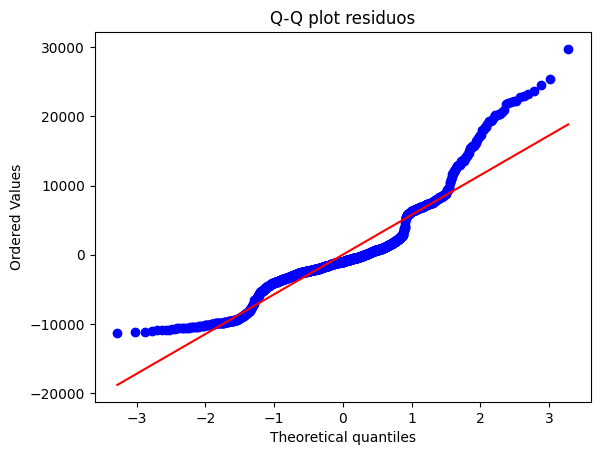

In [ ]:
#residuos do Q-Q PLOT
sts.probplot(residuos, dist = 'norm', plot = plt)
plt.title('Q-Q plot residuos')

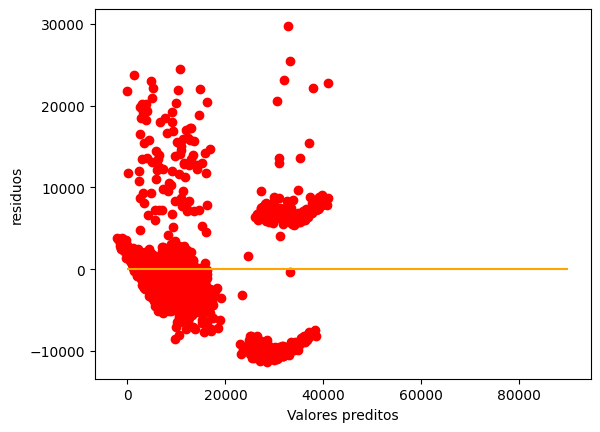

In [ ]:
#analise grafica para ver homocedasticidade dos residuos
plt.scatter(y = residuos, x = multipla_sts.predict(), color = 'red')
plt.hlines(y = 0, xmin =0, xmax= 90000, color = 'orange')
plt.ylabel('residuos')
plt.xlabel('Valores preditos')
plt.show()

In [ ]:
#indica não homocedasticidade
estatistica, p, f, fp = sms.het_breuschpagan(multipla_sts.resid, multipla_sts.model.exog)
print('P valor: {}'.format(p))

P valor: 6.1066794722782446e-24


In [ ]:
#outliers
outliers = multipla_sts.outlier_test()
print(f'Outliers minimo: {outliers.min()}, outlier maximo: {outliers.max()}')

Outliers minimo: student_resid   -1.880403e+00
unadj_p          7.713955e-07
bonf(p)          1.032127e-03
dtype: float64, outlier maximo: student_resid    4.966191
unadj_p          0.999820
bonf(p)          1.000000
dtype: float64


In [ ]:
#Ausência de multicolinearidade
#considerada multicolinearidade quando r > 0.9
variaveis = dados_encoding[['age','sex','bmi','children','smoker','region']]
correlacoes = variaveis.corr(method = 'pearson')
correlacoes

,age,sex,bmi,children,smoker,region
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000


Equação = -11767.65 + (260.16)*age + (-308.28)*sex + (328.66)*bmi + (602.34)*children + (24031.93)*smoker + (-328.18)*region



In [ ]:
#comparando dados previstos com os dados reais
dados_encoding['Previsao'] = multipla_sts.fittedvalues
dados_encoding.head()


,age,sex,bmi,children,smoker,region,charges,Previsao
0,19,0,27.900,0,1,3,16884.92400,25111.241864
1,18,1,33.770,1,0,2,1725.55230,3687.605173
2,28,1,33.000,3,0,2,4449.46200,6963.145707
3,33,1,22.705,0,0,1,21984.47061,3741.308405
4,32,1,28.880,0,0,1,3866.85520,5537.640897


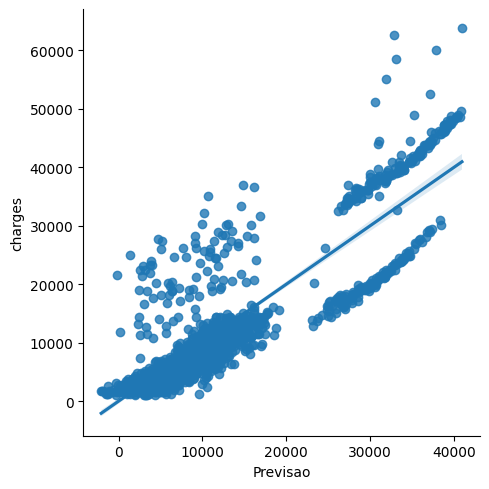

In [ ]:
#ajuste da reta em relação a distribuição dos dados
sns.lmplot(x = 'Previsao', y = 'charges', data = dados_encoding)

#**PRE-PROCESSAMENTO: CRIAÇÃO DOS PIPELINE - DATA LEAKAGE**

**SEPERANDO AS FEATURES, TARGET E DIVIDINDO EM TREINO E TESTE (ANTES DE QUALQUER PRÉ-PROCESSAMENTO, PARA EVITAR VAZAMENTO DE DADOS)**

In [ ]:
#sepanrado as features
features = dados.drop('charges', axis = 1)
features.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [ ]:
#separando o alvo
tagert = dados['charges']
tagert.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


In [ ]:
# separação de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(features, tagert, test_size = 0.3, random_state = 10)


**DIVIDINDO AS VARAIVEIS EM SUAS CATEGORIAS PARA INICAR O PRE-PROCESSAMENTO**

In [ ]:
#features separadas para serem pre processadas
numericas = ['age', 'bmi','children']
binarios = ['sex','smoker']
categoricas = ['region']

**PRE-PROCESSAMENTO EXECUTADO**

pre_processamento_SVR = categoricas (multiclass) = criação de varaiveis dummy, numericas = escalonamento padrão, binarias = encoding (0 ou 1) com OrdinalEncoding

pre_processamento_Arvores = binarias = encoding (0 ou 1) com OrdinalEncoding, categorias = criação de variaveis dummy com OneHotEncoder

**KFold que será utilizado:**

kfold = KFold(n_splits = 15,shuffle = True,random_state = 10)



In [ ]:
# pipeline que será utilizado para a REGRESSÃO COM VETORES DE SUPORTE (SVR)
pre_processamento_SVR = ColumnTransformer(
    transformers=[
        ('binari', OrdinalEncoder(), binarios),
        ('categoric', OneHotEncoder(drop = 'first'), categoricas),
        ('numeric', StandardScaler(), numericas)
    ]
 )
#exibe o pre-processamento
pre_processamento_SVR

# pipeline que será utilizado para DECISION TREE, RANDOM FOREST, XGBOOST, LIGHTGBM, CATBOOST
pre_processamento_Arvore = ColumnTransformer(
    transformers = [
        ('binari',OrdinalEncoder(), binarios),
        ('categoric', OneHotEncoder(drop = 'first'), categoricas),
        ('numeric', StandardScaler(), numericas)
    ]
)
#exibe o pre-processamento
pre_processamento_Arvore

ColumnTransformer(transformers=[('binari', OrdinalEncoder(), ['sex', 'smoker']),
                                ('categoric', OneHotEncoder(drop='first'),
                                 ['region']),
                                ('numeric', StandardScaler(),
                                 ['age', 'bmi', 'children'])])

**PIPELINES QUE SERÃO UTILIZADOS PARA O ALGORTIMOS DE ML**

In [ ]:
# SVR
pipeline_SVR = Pipeline(steps = [
    ('preprocess', pre_processamento_SVR),
    ('model', SVR(kernel = 'rbf'))
])
#escalonando o target
svr_escalonado = TransformedTargetRegressor(
    regressor = pipeline_SVR,
    transformer = StandardScaler()
)
# Decision Tree
pipeline_Decision = Pipeline(steps = [
    ('preprocess', pre_processamento_Arvore),
    ('model', DecisionTreeRegressor())
])
# Escalonando o target para arvore de decisão
decision_escalonado = TransformedTargetRegressor(
    regressor = pipeline_Decision,
    transformer = StandardScaler()
)

# Random Forest
pipeline_Random = Pipeline(steps = [
    ('preprocess', pre_processamento_Arvore),
    ('model', RandomForestRegressor())
])
# Escalonando o target para Random Forest
forest_escalonado = TransformedTargetRegressor(
    regressor = pipeline_Random,
    transformer = StandardScaler()
)

# XGBOOST
pipeline_XGB = Pipeline(steps = [
    ('preprocess', pre_processamento_Arvore),
    ('model', XGBR())
])

# Escalonando o target para XGBOOST
XGB_escalonado = TransformedTargetRegressor(
    regressor = pipeline_XGB,
    transformer = StandardScaler()
)


# lightgbm
pipeline_LIGHT = Pipeline(steps = [
    ('preprocess', pre_processamento_Arvore),
    ('model', LHTR())
])

# Escalonando o target para LIGHTGMB
LHT_escalonado = TransformedTargetRegressor(
    regressor = pipeline_LIGHT,
    transformer = StandardScaler()
)


# catboost
pipeline_CAT = Pipeline(steps = [
    ('preprocess', pre_processamento_Arvore),
    ('model', CTBR())
])
# Escalonando o target para CATBOOST
CAT_escalonado = TransformedTargetRegressor(
    regressor = pipeline_CAT,
    transformer = StandardScaler()
)
pipeline_MLP = Pipeline(steps =[
    ('preprocess', pre_processamento_Arvore),
    ('model',MLPRegressor())
])
MLP_escalonado = TransformedTargetRegressor(
    regressor = pipeline_MLP,
    transformer = StandardScaler()
)

#**REGRESSÃO COM VETORES DE SUPORTE (SVR)**

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [ ]:
#Treinando o modelo com os dados de treino.
svr_escalonado.fit(x_treino, y_treino)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model', SVR())]),
                           transformer=StandardScaler())

In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(svr_escalonado.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(svr_escalonado.score(x_teste, y_teste)))


Coeficiente de Determinação(Treino): 85.97%
Coeficiente de Determinação(Teste): 82.42%


In [ ]:
#previsões do teste
previsoes = svr_escalonado.predict(x_teste)
previsoes

array([ 7687.10238902,  5819.01149175, 13727.43395314, 14190.31338792,
        4366.5747248 ,  8610.14126208, 10244.61043548, 18214.87222524,
        9371.08286212, 17347.80027853,  3470.78782511,  4517.29911592,
        7857.89981558,  9724.55441612, 10505.70822186, 14283.31164711,
        2140.67424032, 16097.9877613 , 12112.41354646, 25076.49719741,
       36068.59561099,  3340.27447172,  3413.64262307,  7718.77230574,
        4282.73646524, 13866.71454364,  8552.14468674, 12351.88103648,
        5138.0410476 , 27324.74762169,  2394.14164628, 40247.33693696,
        7842.18988674,  9019.47661127,  4287.37564645,  6887.87296429,
       14085.91187715, 10290.36661166, 10619.92929306,  8863.84586196,
       14945.26986941, 10317.86121132,  5775.92776936,  8661.83404789,
        3733.8692296 ,  7291.19939965,  9874.31577304, 33294.43739271,
       13287.11612217, 12610.22221079, 39797.5999076 ,  2944.33106068,
        8499.50552198, 14707.26071546, 10722.85276311, 13983.13049159,
      

In [ ]:
#comparando com target real
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#Erro médio absoluto
mean_absolute_error(y_teste, previsoes)

2585.2594249553495

In [ ]:
#Erro medio quadratico
mean_squared_error(y_teste, previsoes)

22828353.326455396

In [ ]:
#Raiz do erro médio quadratico
np.sqrt(mean_squared_error(y_teste, previsoes))

np.float64(4777.902607468615)

**VALIDAÇÃO CRUZADA**

In [ ]:
#determinando o fold e realizando a validação cruzada para o coeficiente de determinação médio
kfold = KFold(n_splits = 15, shuffle = True, random_state= 0)
resultado = cross_val_score(svr_escalonado, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 83.24%


#**DECISION TREE**

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
# modelo com as features e targer pre-processados
decision_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      DecisionTreeRegressor())]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__criterion = ['squared_error', 'friedman_mse', 'absolute_error'], regressor__model__random_state = [5,15,20,48,3], regressor__model__max_depth = [5,10,3,9,12])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__criterion']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__max_depth']))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_arvore = GridSearchCV(decision_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_arvore.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_arvore.best_params_))
print('Melhor score: {}'.format(grid_arvore.best_score_))
#define os melhores hiperparametros do modelo e atribui a variavel
melhor_pipeline = grid_arvore.best_estimator_

Numero de combinações de hiperparametros: 75
Melhor hiperparametro: {'regressor__model__criterion': 'absolute_error', 'regressor__model__max_depth': 5, 'regressor__model__random_state': 48}
Melhor score: 0.8478937954814963


In [ ]:
#Coeficiente de determinação do treino e do teste
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline.score(x_treino, y_treino)))
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline.score(x_teste, y_teste)))

Coeficiente de Determinação: 86.28%
Coeficiente de Determinação: 84.13%


In [ ]:
#realizando as previsões do teste para comparar no olho com o target real
previsoes = melhor_pipeline.predict(x_teste)
previsoes

array([ 7151.092   ,  5978.28105 , 13837.9562  , 13837.9562  ,
        3862.307225,  5978.28105 ,  8857.20925 , 17560.37975 ,
        8857.20925 , 22218.1149  ,  3693.428   ,  2643.2685  ,
        8023.13545 ,  7151.092   ,  9120.45015 , 13837.9562  ,
        2643.2685  , 13837.9562  , 11841.608525, 19629.46885 ,
       41097.16175 ,  1842.519   ,  1842.519   ,  5978.28105 ,
        4892.3764  , 13837.9562  ,  8857.20925 , 11841.608525,
        3693.428   , 19629.46885 ,  1842.519   , 39919.925625,
        8023.13545 ,  8857.20925 ,  4892.3764  ,  7151.092   ,
       13837.9562  , 11113.4391  ,  9120.45015 ,  8857.20925 ,
       13837.9562  , 10631.56705 ,  5978.28105 ,  8023.13545 ,
        1842.519   ,  5978.28105 ,  8023.13545 , 37486.014   ,
       13837.9562  , 11841.608525, 37165.1638  ,  3862.307225,
        8023.13545 , 11841.608525, 11113.4391  , 13837.9562  ,
       11841.608525,  5978.28105 ,  5978.28105 , 41097.16175 ,
        1842.519   , 22218.1149  , 28868.6639  ,  2643.

In [ ]:
#para ser comparado com as previsoes (target real)
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO AS METRICAS DE DESEMPENHO DO MODELO**

In [ ]:
#Metricas de desempenho do modelo.
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes)))
print('Coeficiente de determinação (R2): {} '.format(r2_score(y_teste, previsoes)))
print('Raiz quadrada do erro médio(RMSE): {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes))))

Erro médio absoluto: 2010.443750146766
Coeficiente de determinação (R2): 0.8413105496161755 
Raiz quadrada do erro médio(RMSE): 4539.501725081243


**VALIDAÇÃO CRUZADA DO MODELO**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 83.38%


#**RANDOM FOREST**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
# modelo com as features e targer pre-processados
forest_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      RandomForestRegressor())]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,10,8], regressor__model__random_state = [5,15,20,48,3], regressor__model__n_estimators = [60,100,150,180,200])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators']))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_random = GridSearchCV(forest_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_random.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_random.best_params_))
print('Melhor score: {}'.format(grid_random.best_score_))
#criando o modelo ja com os melhores hyperparametros
melhor_pipeline_RF = grid_random.best_estimator_

Numero de combinações de hiperparametros: 125
Melhor hiperparametro: {'regressor__model__max_depth': 5, 'regressor__model__n_estimators': 100, 'regressor__model__random_state': 3}
Melhor score: 0.8574892260073853


In [ ]:
#coeficiente de determinação do treino e teste
print('Coeficiente de determinação(treino): {:.2%}'.format(melhor_pipeline_RF.score(x_treino, y_treino)))
print('Coeficiente de determinação(teste): {:.2%}'.format(melhor_pipeline_RF.score(x_teste, y_teste)))

Coeficiente de determinação(treino): 89.44%
Coeficiente de determinação(teste): 85.83%


In [ ]:
#previsoes feitas
previsoes_rf = melhor_pipeline_RF.predict(x_teste)
previsoes_rf

array([ 7344.62272124,  6238.17384297, 17303.22956665, 14538.92603136,
        4618.2790399 ,  7291.51837667,  9567.88391548, 18818.67386055,
        9544.32508562, 21779.52529103,  6989.35834518,  4078.31402665,
        7743.47956953,  7654.97923105,  9979.025033  , 14331.27717042,
        4786.92639538, 18810.56407941, 12338.16314905, 19683.24952099,
       41876.21729217,  2688.86853531,  2517.26981517,  6942.33623784,
        5936.24470856, 13905.0471097 ,  9863.50912507, 14464.53480122,
        5503.18383779, 20671.12852511,  2578.30195321, 39698.30765631,
        8978.96128604,  9629.0720405 ,  6330.09731247,  7907.44250698,
       14002.51282878, 12392.46019238, 11329.86466512, 10532.34312366,
       14217.04873583, 11133.90244744,  6238.17384297,  8701.23429313,
        2775.44589196,  7178.74867864,  9416.52773794, 40273.79145716,
       14140.17276122, 12607.38768592, 40660.51697212,  4651.40488175,
        9243.2336695 , 14651.1514767 , 12352.92591009, 14083.60798198,
      

**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#erro medio absoluto e raiz do erro quadratico medio
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_rf)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_rf))))


Erro médio absoluto: 2415.7053150921906
Raiz do erro quatrático médio: 4289.224855746106


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada do modelo
resultado = cross_val_score(melhor_pipeline_RF, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.35%


#**XGBOOST**

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [ ]:
# modelo com as features e targer pre-processados
XGB_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsamp...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,10,8], regressor__model__random_state = [5,15,3], regressor__model__n_estimators = [60,100,150,180,], regressor__model__learning_rate = [0.01,0.05,0.08,0.03,0.1])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators'] * len(parametros_grid['regressor__model__learning_rate'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_XG = GridSearchCV(XGB_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_XG.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_XG.best_params_))
print('Melhor score: {:.2%}'.format(grid_XG.best_score_))
melhor_pipeline_XG = grid_XG.best_estimator_

Numero de combinações de hiperparametros: 300
Melhor hiperparametro: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 60, 'regressor__model__random_state': 5}
Melhor score: 85.89%


In [ ]:
#Coeficiente de determinação do treino e teste
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline_XG.score(x_treino, y_treino)))
print('Coeficiente de Determinação: {:.2%}'.format(melhor_pipeline_XG.score(x_teste, y_teste)))

Coeficiente de Determinação: 87.56%
Coeficiente de Determinação: 85.80%


In [ ]:
#previsoes do modelo
previsoes_XG = melhor_pipeline_XG.predict(x_teste)
previsoes_XG

array([ 8021.0923,  6413.321 , 16739.334 , 14269.751 ,  4575.334 ,
        7971.922 , 10277.831 , 18959.53  ,  9904.829 , 22763.928 ,
        4886.323 ,  4268.621 ,  8615.432 ,  8541.837 , 10389.721 ,
       14269.751 ,  5233.415 , 17065.8   , 12351.797 , 21588.008 ,
       40538.09  ,  3251.2122,  2885.551 ,  7451.1772,  6110.042 ,
       14525.127 , 10266.848 , 13723.298 ,  5672.422 , 21998.156 ,
        2020.2716, 39226.34  ,  9123.08  ,  9292.663 ,  6154.1807,
        8226.346 , 14381.589 , 12663.187 ,  9804.167 , 10098.995 ,
       14692.9795, 10997.588 ,  6413.321 ,  9290.933 ,  3484.176 ,
        7758.6855,  8722.749 , 38092.168 , 14269.751 , 12370.866 ,
       39003.523 ,  4788.5703,  9529.08  , 14360.063 , 12626.242 ,
       14525.127 , 13149.223 ,  7320.2695,  7841.0137, 41560.883 ,
        2885.551 , 24290.951 , 26779.695 ,  3351.6155, 19728.455 ,
        8992.172 ,  6323.2783,  8541.837 ,  9529.08  ,  9204.006 ,
        8503.594 ,  4216.006 ,  7971.922 ,  8541.837 ,  9659.9

In [ ]:
#target real para comprar com as previsoes
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_XG)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_XG))))


Erro médio absoluto: 2494.2957962978467
Raiz do erro quatrático médio: 4294.461524597512


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_XG, features, tagert, cv = kfold, scoring= 'r2')
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.64%


#**LIGHTGBM**

https://colab.research.google.com/drive/1PThpTTfytAd-54-2KYaV91rLz9dgaTy_#scrollTo=d97GRWSiiEva

In [ ]:
#modelo com as features e target pre-processados
LHT_escalonado

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('binari',
                                                                                       OrdinalEncoder(),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('categoric',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['region']),
                                                                                      ('numeric',
                                                                                       StandardScaler(),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      LGBMRegressor())]),
                           transformer=StandardScaler())

In [ ]:
parametros_grid = dict(regressor__model__max_depth = [5,7,2,8], regressor__model__random_state = [5,15,3], regressor__model__n_estimators = [60,150,180], regressor__model__learning_rate = [0.01,0.05,0.03], regressor__model__num_leaves = [50,120,80,150], regressor__model__verbose = [-1])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__max_depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__n_estimators'] * len(parametros_grid['regressor__model__learning_rate']
                                                                                                                                                                                                      * len(parametros_grid['regressor__model__num_leaves'] * len(parametros_grid['regressor__model__verbose'])))))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_LHT = GridSearchCV(LHT_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_LHT.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_LHT.best_params_))
print('Melhor score: {:.2%}'.format(grid_LHT.best_score_))
#criando o modelos com os melhores parametros
melhor_pipeline_LHT = grid_LHT.best_estimator_


Numero de combinações de hiperparametros: 432
Melhor hiperparametro: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 150, 'regressor__model__num_leaves': 50, 'regressor__model__random_state': 5, 'regressor__model__verbose': -1}
Melhor score: 85.93%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_LHT.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_LHT.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 87.56%
Coeficiente de Determinação(Teste): 85.57%


In [ ]:
#previsoes
previsoes_LHT = grid_LHT.predict(x_teste)
previsoes_LHT

array([ 7977.86046692,  6311.83821127, 17514.07892596, 14206.20598055,
        4494.18356849,  8089.30483701, 10758.18074126, 19214.05430618,
        9851.48046655, 22753.82422617,  4628.3456626 ,  4253.34072959,
        8422.64461598,  8655.74584987, 10519.25410122, 14206.20598055,
        5302.52481044, 17309.61163514, 12181.48878788, 21612.8607122 ,
       40590.29334039,  3381.61457527,  2249.60391726,  7411.41945407,
        5990.19918541, 14655.55168645, 10280.37353977, 13544.85738533,
        5646.66666342, 21739.44630894,  1491.94823953, 39078.56530607,
        8974.23066803,  9157.76792832,  6143.36498912,  8513.42093999,
       14127.14765608, 12884.82580395,  9833.21882252,  9733.84634845,
       15061.23551774, 10858.70093848,  6326.85424185,  9442.58487137,
        3525.68946166,  7646.73238432,  8521.58889938, 38387.78852879,
       14142.16368667, 12421.17308319, 39231.78835909,  4691.95728286,
        9287.01481239, 14428.35805117, 12657.40347167, 14591.50939257,
      

In [ ]:
#target atual
y_teste

,charges
7,7281.50560
999,5267.81815
1209,12347.17200
491,24513.09126
625,3736.46470
...,...
854,24106.91255
554,17878.90068
1278,22462.04375
374,1391.52870


**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_LHT)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_LHT))))

Erro médio absoluto: 2481.0226050759134
Raiz do erro quatrático médio: 4328.850075557876


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_LHT, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.43%


#**CATBOOST**

https://catboost.ai/docs/en/concepts/python-reference_catboostregressor

In [ ]:
parametros_grid = dict(regressor__model__depth = [5,7,2,8], regressor__model__random_state = [5,15,3], regressor__model__iterations = [100,150,220,280], regressor__model__learning_rate = [0.01,0.05,0.03])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__depth']) * len(parametros_grid['regressor__model__random_state'] * len(parametros_grid['regressor__model__iterations'] * len(parametros_grid['regressor__model__learning_rate'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_CAT = GridSearchCV(CAT_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_CAT.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_CAT.best_params_))
print('Melhor score: {:.2%}'.format(grid_CAT.best_score_))
melhor_pipeline_CAT = grid_CAT.best_estimator_

A saída de streaming foi truncada nas últimas 5000 linhas.
192:	learn: 0.2526144	total: 356ms	remaining: 160ms
193:	learn: 0.2520541	total: 358ms	remaining: 159ms
194:	learn: 0.2517444	total: 359ms	remaining: 157ms
195:	learn: 0.2513616	total: 361ms	remaining: 155ms
196:	learn: 0.2509570	total: 363ms	remaining: 153ms
197:	learn: 0.2505377	total: 365ms	remaining: 151ms
198:	learn: 0.2503976	total: 367ms	remaining: 149ms
199:	learn: 0.2501193	total: 368ms	remaining: 147ms
200:	learn: 0.2498150	total: 370ms	remaining: 145ms
201:	learn: 0.2496566	total: 372ms	remaining: 144ms
202:	learn: 0.2494803	total: 374ms	remaining: 142ms
203:	learn: 0.2492627	total: 375ms	remaining: 140ms
204:	learn: 0.2491037	total: 377ms	remaining: 138ms
205:	learn: 0.2484659	total: 379ms	remaining: 136ms
206:	learn: 0.2482801	total: 381ms	remaining: 134ms
207:	learn: 0.2477737	total: 382ms	remaining: 132ms
208:	learn: 0.2476879	total: 384ms	remaining: 130ms
209:	learn: 0.2474328	total: 386ms	remaining: 129ms
210:	

In [ ]:
#melhores parametros e melhor score
print('Melhor hiperparametro: {}'.format(grid_CAT.best_params_))
print('Melhor score: {:.2%}'.format(grid_CAT.best_score_))


Melhor hiperparametro: {'regressor__model__depth': 5, 'regressor__model__iterations': 150, 'regressor__model__learning_rate': 0.05, 'regressor__model__random_state': 15}
Melhor score: 86.05%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_CAT.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_CAT.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 88.89%
Coeficiente de Determinação(Teste): 85.49%


In [ ]:
#previsoes
previsoes_CAT = melhor_pipeline_CAT.predict(x_teste)
previsoes_CAT

array([ 7713.21308112,  5833.24598215, 16592.70160789, 14954.35681677,
        4167.29907111,  8383.57960676, 10363.60263776, 18122.57171397,
       10113.65443323, 21143.76819468,  5664.83720228,  3982.47220935,
        8345.82024997,  9257.59543738, 10551.50217054, 14585.49677612,
        4716.9708267 , 17621.26598243, 12858.63037058, 21483.14507676,
       40429.33625762,  3339.19852482,  2488.84866239,  7038.46303406,
        5895.33072547, 14164.52668267,  9773.87831143, 12908.47546177,
        5775.10889016, 22388.43423428,  1883.55009666, 39834.77176606,
        8730.14479768,  9285.39118988,  5818.43593669,  7770.31497427,
       14183.75210777, 10631.19127695, 10441.66729286,  9716.96309396,
       14838.85146579, 10885.5306441 ,  5855.29519347,  8949.84841576,
        2760.716914  ,  8780.52491753,  8834.88306538, 37776.79865418,
       13821.81828389, 12726.82560966, 41009.00126927,  3861.86520151,
        9109.0751206 , 16511.10552398, 11236.38250278, 14195.99586754,
      

**AVALIANDO METRICAS DE DESEMPENHO**

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_CAT)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_CAT))))

Erro médio absoluto: 2450.496434715817
Raiz do erro quatrático médio: 4341.305349161423


**VALIDAÇÃO CRUZADA**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_CAT, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

0:	learn: 0.9641592	total: 756us	remaining: 113ms
1:	learn: 0.9285215	total: 1.36ms	remaining: 100ms
2:	learn: 0.8954525	total: 1.95ms	remaining: 95.7ms
3:	learn: 0.8633889	total: 2.49ms	remaining: 90.8ms
4:	learn: 0.8337069	total: 3.36ms	remaining: 97.6ms
5:	learn: 0.8068932	total: 3.99ms	remaining: 95.7ms
6:	learn: 0.7794558	total: 5.11ms	remaining: 104ms
7:	learn: 0.7531400	total: 5.74ms	remaining: 102ms
8:	learn: 0.7279788	total: 6.72ms	remaining: 105ms
9:	learn: 0.7063716	total: 7.04ms	remaining: 98.6ms
10:	learn: 0.6854055	total: 7.62ms	remaining: 96.3ms
11:	learn: 0.6642801	total: 8.17ms	remaining: 94ms
12:	learn: 0.6441039	total: 8.7ms	remaining: 91.7ms
13:	learn: 0.6257366	total: 9.25ms	remaining: 89.9ms
14:	learn: 0.6088921	total: 9.78ms	remaining: 88.1ms
15:	learn: 0.5931034	total: 10.3ms	remaining: 86.5ms
16:	learn: 0.5775893	total: 10.9ms	remaining: 85.3ms
17:	learn: 0.5632851	total: 11.4ms	remaining: 83.8ms
18:	learn: 0.5507436	total: 11.8ms	remaining: 81ms
19:	learn: 0.5

In [ ]:
#coeficiente de determinação médio
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 85.51%


#**REDE NEURAL (MLPRegressor)**

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [ ]:
parametros_grid = dict(regressor__model__hidden_layer_sizes = [(4,4),(5,5),(7,7),(4)], regressor__model__activation= ['relu','tanh','logistic'], regressor__model__max_iter = [400,500], regressor__model__solver = ['lbfgs','adam'], regressor__model__random_state = [12], regressor__model__verbose = [True])
#Printa a quantidade de combinações geradas pelos hyper
print('Numero de combinações de hiperparametros: {}'.format(len(parametros_grid['regressor__model__hidden_layer_sizes']) * len(parametros_grid['regressor__model__activation'] * len(parametros_grid['regressor__model__max_iter'] * len(parametros_grid['regressor__model__solver']) * len(parametros_grid['regressor__model__verbose'])))))
#define o modelo de ML que será utilizado, os hiperparametros, o scoring e a quantidade de divisões para validação cruzada
grid_MLP = GridSearchCV(MLP_escalonado, parametros_grid, scoring='r2', cv = 4)
#passa os dados de treino para o modelo avaliar os melhores
grid_MLP.fit(x_treino, y_treino)
print('Melhor hiperparametro: {}'.format(grid_MLP.best_params_))
print('Melhor score: {:.2%}'.format(grid_MLP.best_score_))
melhor_pipeline_MLP = grid_MLP.best_estimator_

A saída de streaming foi truncada nas últimas 5000 linhas.
Iteration 336, loss = 0.16201512
Iteration 337, loss = 0.16100281
Iteration 338, loss = 0.16007464
Iteration 339, loss = 0.15920122
Iteration 340, loss = 0.15823576
Iteration 341, loss = 0.15736176
Iteration 342, loss = 0.15649723
Iteration 343, loss = 0.15568427
Iteration 344, loss = 0.15482695
Iteration 345, loss = 0.15402690
Iteration 346, loss = 0.15327610
Iteration 347, loss = 0.15248687
Iteration 348, loss = 0.15172782
Iteration 349, loss = 0.15101355
Iteration 350, loss = 0.15024968
Iteration 351, loss = 0.14951786
Iteration 352, loss = 0.14883639
Iteration 353, loss = 0.14810165
Iteration 354, loss = 0.14748280
Iteration 355, loss = 0.14677966
Iteration 356, loss = 0.14615475
Iteration 357, loss = 0.14553350
Iteration 358, loss = 0.14490650
Iteration 359, loss = 0.14436010
Iteration 360, loss = 0.14372104
Iteration 361, loss = 0.14314145
Iteration 362, loss = 0.14262894
Iteration 363, loss = 0.14206063
Iteration 364, lo

In [ ]:
#melhores parametros e melhor score
print('Melhor hiperparametro: {}'.format(grid_MLP.best_params_))
print('Melhor score: {:.2%}'.format(grid_MLP.best_score_))

Melhor hiperparametro: {'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': 4, 'regressor__model__max_iter': 500, 'regressor__model__random_state': 12, 'regressor__model__solver': 'lbfgs', 'regressor__model__verbose': True}
Melhor score: 85.18%


In [ ]:
#coeficiente de determinação médio
print('Coeficiente de Determinação(Treino): {:.2%}'.format(melhor_pipeline_MLP.score(x_treino, y_treino)))
print('Coeficiente de Determinação(Teste): {:.2%}'.format(melhor_pipeline_MLP.score(x_teste, y_teste)))

Coeficiente de Determinação(Treino): 87.09%
Coeficiente de Determinação(Teste): 83.95%


In [ ]:
#previsoes
previsoes_MLP = melhor_pipeline_MLP.predict(x_teste)
previsoes_MLP

array([ 9659.37121769,  7027.55583769, 12310.54999476, 14400.88382977,
        5577.53574643,  9805.57325421,  9832.93001806, 15957.72789418,
        8426.84134281, 23929.63754241,  4190.96229532,  5663.66373164,
        7505.47211398, 11551.08673309, 10190.31493541, 14822.29764516,
        2409.86454759, 15766.19428886, 13133.08920015, 21506.56146247,
       39180.15620007,  5054.99575563,  4074.49143819,  8518.7660669 ,
        5562.03588477, 15296.02154203,  9305.50821524, 12734.6934853 ,
        7065.00726913, 28947.58409065,  1911.61810033, 40946.43302558,
        9985.71403085,  8421.29874481,  3579.39676389,  6810.54315628,
       15623.30308552,  9585.6478134 , 10653.29876359,  9291.14575757,
       15056.58403412, 11015.79447226,  6857.15277253,  9653.77522091,
         536.63641751,  7803.11656854,  7810.89832411, 28781.09452908,
       13756.43051183, 13305.70890468, 41279.67054105,  2650.58287443,
       12848.22444781, 15677.75123948, 11721.68001763, 13491.60812346,
      

In [ ]:
#metricas de desempenho do modelo
print('Erro médio absoluto: {}'.format(mean_absolute_error(y_teste, previsoes_MLP)))
print('Raiz do erro quatrático médio: {}'.format(np.sqrt(mean_squared_error(y_teste, previsoes_MLP))))

Erro médio absoluto: 2646.048215166554
Raiz do erro quatrático médio: 4565.367301900449


**Validação cruzada**

In [ ]:
#validação cruzada
resultado = cross_val_score(melhor_pipeline_MLP, features, tagert, cv = kfold)
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 84.70%


In [ ]:
print('Coeficiente de determinação médio: {:.2%}'.format(resultado.mean()))

Coeficiente de determinação médio: 84.70%


#**ESTATISTICA DOS ALGORTIMOS**

**REGRESSÃO LINEAR SIMPLES (charges ~ age): R^2 = 8.2/10.2, RMSE = 11295.5, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 7.09%**

**REGRESSÃO LINEAR SIMPLES (charges ~ smoker): R^2 = 62/63, RMSE = 7298.1, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 59.85%**

**REGRESSÃO LINEAR MULTIPLA: R^2 = 75/76, RMSE = 5872.2, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 73.73%**

**VETORES DE SUPORTE (SVR): R^2: 85.97/82.42, RMSE = 4777.90, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 83.24%**

**ARVORE DE DECISÃO: R^2: 86.28./84.13, RMSE = 4539.50, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 83.28%**

**RANDOM FOREST: R^2: 89.44/85.83, RMSE = 4289.22, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.35% - CAMPEÃO**

**XGBOOST: R^2: 87.56/85.80, RMSE = 4294.46, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.64% - 2º LUGAR**

**LIGHTGBM: R^2: 87.56/85.67, RMSE = 4328.85, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.43% - 3º LUGAR**

**CATBOOST: R^2: 88.89/85.49, RMSE = 4341.30, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 85.51%**

**REDE NEURAL (MLP) R^2: 87.09/83.95, RMSE = 4565.36, COEFICIENTE DE DETERMINAÇÃO MÉDIO: 84.70%**

#**SIMULAÇÃO DE DEPLOY**

In [ ]:
#salva o modelo ja com todo o pipeline (pre-processamento + modelo) EM UM FORMATO PKL
joblib.dump(melhor_pipeline_RF, 'Random_Forest.pkl')
joblib.dump(melhor_pipeline_XG, 'XGBOOST.pkl')
joblib.dump(melhor_pipeline_LHT, 'LIGHTGBM.pkl')

#importando o modelo para o ambiente
modelo_Forest = joblib.load('Random_Forest.pkl')
modelo_XGB = joblib.load('XGBOOST.pkl')
modelo_LHT = joblib.load('LIGHTGBM.pkl')


In [ ]:
#simulador
def previsao_interativa():
  continuar = 'Sim'
  while continuar == 'Sim':

    # Solicitar dados ao usuário (exemplo: seguro saúde)
    idade = int(input("Digite a idade: "))
    bmi = float(input("Digite o BMI (IMC): "))
    filhos = int(input("Digite a quantidade de filhos: "))
    sexo = input("Digite o sexo (male/female): ")
    fumante = input("É fumante? (yes/no): ")
    regiao = input("Digite a região (northeast/southeast/southwest/northwest): ")

    # Organizar em dict
    dados_dict = {
        "age": [idade],
        "bmi": [bmi],
        "children": [filhos],
        "sex": [sexo],
        "smoker": [fumante],
        "region": [regiao]
    }

    #  Converter em DataFrame
    df_input = pd.DataFrame(dados_dict)

    # Escolher o modelo
    escolha = input("Escolha o modelo (forest / xgb / lht): ").strip().lower()

    if escolha == "forest":
        modelo = modelo_Forest
    elif escolha == "xgb":
        modelo = modelo_XGB
    elif escolha == "lht":
        modelo = modelo_LHT
    else:
        print("Modelo inválido, tente novamente.")
        return

    #Realizar previsão
    previsao = modelo.predict(df_input)
    print(f"\nPrevisão ({escolha.upper()}): {previsao[0]:,.2f}")
    #continuar predição
    continuar = str(input('Deseja continuar as previsões? (Sim ou Não): '))

In [ ]:
#executando a simulação de deploy
previsao_interativa()

Digite a idade: 25
Digite o BMI (IMC): 28.5
Digite a quantidade de filhos: 2
Digite o sexo (male/female): female
É fumante? (yes/no): no
Digite a região (northeast/southeast/southwest/northwest): northeast
Escolha o modelo (forest / xgb / lht): forest

Previsão (FOREST): 5,208.93
Deseja continuar as previsões? (Sim ou Não): sim


In [2]:
#Extraindo as tecnologias utilizadas no projeto
!pip freeze > requirements.txt

#**SIGNIFICADO DAS VARIAVEIS**

**Significado das features e target, tipo de variavel**

**Features**:

**age** = idade da pessoa - tipo:(int)

**sex** = sexo da pessoa, male = homem, female, mulher - tipo:(str)

**bmi** = indice de massa corporal, proporcionando uma compreensão do corpo, pesos que são relativamente altos ou baixos em relação à altura. índice objetivo de peso corporal (kg/m^2) usando a relação altura/peso, idealmente 18,5 a 24,9 - tipo: (float)

**children** = numero de filhos cobertos pelo seguro de saúde / número de dependentes, tipo: (int).

**smoker** = se a pessoa é fumante - yes = fumante, no = não fumante - tipo:(str)

**region** = região do beneficiario no territorio do EUA. Norte = northeast, Sul = southeast, Sudoweast = southwest, Nordest = northwest - tipo:(str)

**target**:

charges = custo médico individual faturado por health insurance (empresa) - tipo:(float)

